# Swiss Covid-19 Data Analysis

### Import and Basic Config

In [13]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

data_url = 'https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total_v2.csv'

### Helper Functions

In [51]:
def pivot_variable(df, values):
    return df.pivot(columns='abbreviation_canton_and_fl', values=values).ffill().fillna(0)

def total_average(df):
    return df.sum(axis=1).iloc[:-1].rolling(7, center=True).mean()

def plot(df, ax, **kwargs):
        
    df.plot.line(xlabel='', ax=ax, **kwargs)

    ax.set_title('Schweiz (7-Tage Mittel)', fontsize=18)

    lines = ax.get_lines()
    axes = [ax]
    if hasattr(ax, 'right_ax'):
        axes.append(ax.right_ax)
        right_lines = ax.right_ax.get_lines()
        for l in right_lines:
            l.set_label(l.get_label() + ' (rechts)')
        lines += right_lines
        ax.right_ax.grid(False)

    ax.legend(lines, [l.get_label() for l in lines], loc='upper center', ncol=3, prop={'size': 14})

    for a in axes:
        a.tick_params(axis='both', labelsize=14)
        mplcyberpunk.add_glow_effects(a)

    ax.grid(axis='both')

### Load Data and Drop Unused Columns and Liechtenstein

In [52]:
data = pd.read_csv(data_url, parse_dates=['date'])
data.drop((data['abbreviation_canton_and_fl'] == 'FL').index)
data = data.drop(columns=['time', 'source']).set_index(['date'])

### Extract Variables of Interest and Pivot by Canton

In [67]:
ncumul_conf = pivot_variable(data, 'ncumul_conf')
current_hosp = pivot_variable(data, 'current_hosp')
ncumul_deceased = pivot_variable(data, 'ncumul_deceased')
new_hosp = pivot_variable(data, 'new_hosp')

### Build Dataframes of Interesting Swiss Totals

The daily new confirmed cases are calculated from the cumulative variable by taking the differences. The total hospitalization is the cumulative sum of the daily new hospitalizations.

In [107]:
df_daily = pd.concat([
    total_average(ncumul_conf.diff()).rename('Neu bestätigt'),
    total_average(current_hosp).rename('Aktuell hospitalisiert'),
    total_average(ncumul_deceased.diff()).rename('Neu verstorben'),
], axis=1)

df_cumul = pd.concat([
    total_average(ncumul_conf).rename('Total bestätigt'),
    total_average(new_hosp.cumsum()).rename('Total hospitalisiert'),
    total_average(ncumul_deceased).rename('Total verstorben'),
], axis=1)

### Create the Plot

Cyberpunk style...

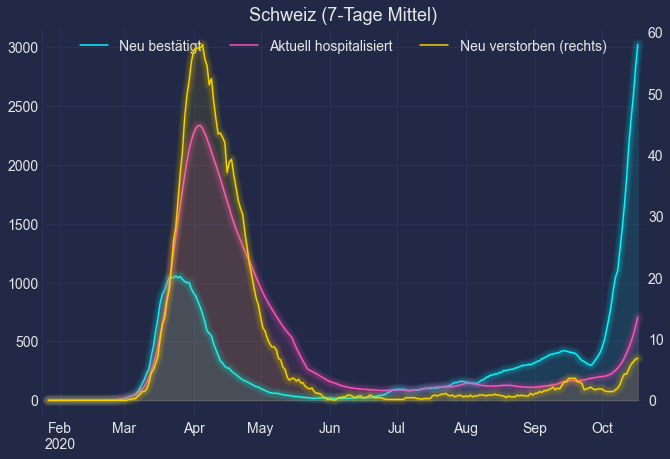

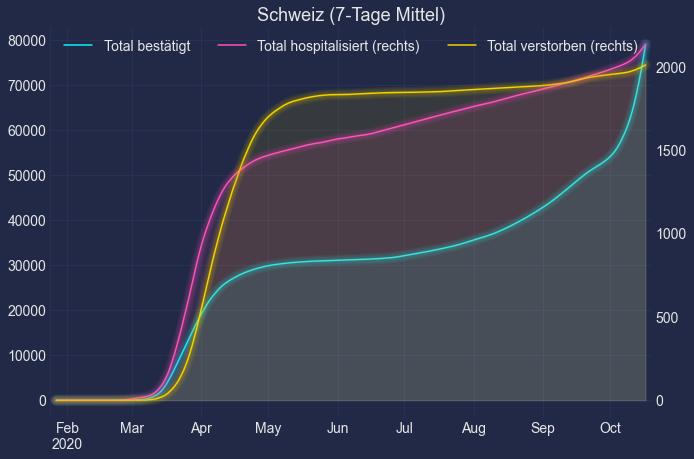

In [108]:
plt.close('all')

plt.figure()
ax = plt.subplot(1, 1, 1)
ax.figure.set_size_inches((1.8*6, 1.8*4))
plot(df_daily, ax, secondary_y=['Neu verstorben',])

plt.figure()
ax = plt.subplot(1, 1, 1)
ax.figure.set_size_inches((1.8*6, 1.8*4))
plot(df_cumul, ax, secondary_y=['Total hospitalisiert', 'Total verstorben',])